In [4]:
import numpy as np
from matplotlib import pyplot as plt
import math
import time
import cProfile
import pstats

In [5]:
class Graph:
    def __init__(self, vertex_set, edge_set):
        self.V = vertex_set
        self.E = edge_set
    
    def easy_access(self):
        self.V_E_map = []
        for v in range(len(self.V)):
            self.V_E_map.append([])
        for e in self.E:
            self.V_E_map[e[0]].append(e[1])
            if e[1] != e[0]: 
                self.V_E_map[e[1]].append(e[0])

    def copy(self):
        v = self.V.copy()
        e = self.E.copy()
        g = Graph(v, e)
        if hasattr(self, 'V_E_map'):
            g.easy_access()
        return g

In [6]:
class SquareLattice(Graph):
    def __init__(self, dimension, length):

        self.dim = dimension
        self.len = length

        v = []
        e = []

        #numpy array
        for i in range(self.len ** self.dim):
            v.append(self.base_convert(i))
            for d in range(self.dim):
                if v[i][d] < self.len - 1:
                    e += [[i, i + length ** d]]
        
        self.V = v
        self.E = e

    def base_convert(self, value, reverse = False):
        if reverse:
            v = 0
            for d in range(self.dim):
                v += value[d] * (self.len ** self.dim)
            return v

        else:
            v = []
            for d in range(self.dim):
                value = value // (self.len ** d)
                v += [value % self.len]
            return v

In [7]:
class IsingModel:
    def __init__(self, graph, b, init):
        self.graph = graph.copy()
        self.graph.easy_access()
        self.b = b

        if 0 < init and init < 1:
            for i in range(len(self.graph.V)):
                self.graph.V[i] = np.random.binomial(1, init)
        elif init == 1:
            self.graph.V = [1 for i in self.graph.V]
        elif init == -1:
            self.graph.V = [-1 for i in self.graph.V]
        else:
            self.graph.V = self.graph.V

    def copy(self):
        g = self.graph.copy()
        i = IsingModel(g, self.b, init=False)
        return i

    def equals(self, model):
        if self.graph.V == model.graph.V:
            return True
        else:
            return False

    def print(self):
        print(self.graph.V)

    @staticmethod
    def H(model):
        H = 0
        for e in model.graph.E:
            H -= model.graph.V[e[0]] * model.graph.V[e[1]]

    @staticmethod
    def glaubner_coupling(model, randnum):

        size = len(model.graph.V)
        randnum *= size
        randindex = math.floor(randnum)
        randval = randnum - randindex

        s = sum([model.graph.V[i] for i in model.graph.V_E_map[randindex]])
        p = (1 + math.tanh(model.b * s)) / 2
        
        if randval <= p:
            model.graph.V[randindex] = 1
            
        else:
            model.graph.V[randindex] = -1

        return model

In [8]:
class MonoCFTP:
    def __init__(self, transition_rule, one, zero):
        self.one = one
        self.zero = zero
        self.max = one.copy()
        self.min = zero.copy()
        self.transition_rule = transition_rule

    def next(self, randnum):
        self.min = self.transition_rule(self.min, randnum)
        self.max = self.transition_rule(self.max, randnum)
    
    def sequence(self, r, T0, seed, iter):
        self.min = self.zero.copy()
        self.max = self.one.copy()

        for i in reversed(range(iter)):
            t = T0 * r ** i
            rng = np.random.default_rng(seed = seed * (i + 2))
            rands = rng.random(t)
            for randnum in rands:
                self.next(randnum)

        t = T0
        rng = np.random.default_rng(seed = seed)
        rands = rng.random(t)
        for randnum in rands:
            self.next(randnum)
            
    def sample(self, seed, r, T0):
        iter = 0
        self.max = self.one.copy()
        self.min = self.zero.copy()
        while not self.max.equals(self.min):
            iter += 1
            self.sequence(r, T0, seed, iter)
            print(T0 * (r ** iter))
        return self.max

In [21]:
SIZE = 80
isingGraph = SquareLattice(2, SIZE)

In [30]:
TEMP = .5

isingOne = IsingModel(isingGraph, TEMP, 1)
isingZero = IsingModel(isingGraph, TEMP, -1)

cftp = MonoCFTP(IsingModel.glaubner_coupling, isingOne, isingZero)

In [31]:
t1 = time.time()
cftp.sample(1437, 2, 10000)
print(time.time() - t1)

20000
40000
80000
160000
320000
640000
1280000
2560000
5120000
10240000
20480000


KeyboardInterrupt: 

6400


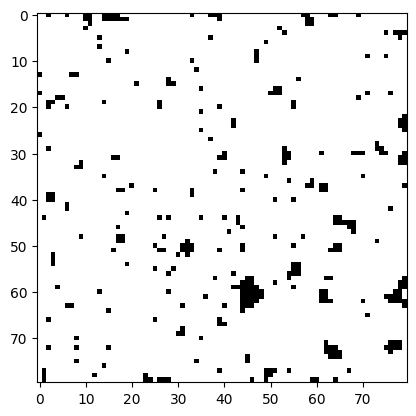

In [32]:
print(len(cftp.max.graph.V))
plt.imshow(np.reshape(np.array([[255,255,255] if x == 1 else [0,0,0] for x in cftp.min.graph.V]), (SIZE, SIZE, 3)))
plt.imshow(np.reshape(np.array([[255,255,255] if x == 1 else [0,0,0] for x in cftp.max.graph.V]), (SIZE, SIZE, 3)))

In [60]:
test = cftp.max.copy()
with cProfile.Profile() as profile:
    cftp.sample(513, 2, 1000)
profile_result = pstats.Stats(profile)
profile_result.print_stats()

2000
4000
8000
16000
32000
64000
128000
256000
512000
1024000
         39829027 function calls in 17.296 seconds

   Random listing order was used

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       20    0.000    0.000    0.000    0.000 {method 'get' of '_contextvars.ContextVar' objects}
    14872    0.001    0.000    0.001    0.000 {method 'keys' of 'dict' objects}
       20    0.000    0.000    0.000    0.000 {method 'items' of 'dict' objects}
     7436    0.001    0.000    0.001    0.000 {method 'values' of 'dict' objects}
       88    0.032    0.000    0.032    0.000 {method 'copy' of 'list' objects}
 13147200    0.690    0.000    0.690    0.000 {method 'append' of 'list' objects}
       44    0.000    0.000    0.000    0.000 {built-in method builtins.hasattr}
     7456    0.001    0.000    0.001    0.000 {built-in method builtins.isinstance}
  4092086    0.288    0.000    0.288    0.000 {built-in method builtins.len}
       10    0.000    0.000    0.00